# Analiza danych klientów banku

Zbiór to dane 10 tys. klientów banku, przygotowany w celu predykcji rezygnacji klienta z konta.

Zbiór został udostępniony na stronie Kaggle: https://www.kaggle.com/santoshd3/bank-customers

#### Cel: zbadać zbiór pod kątem interesujących zależności

In [1]:
# Wczytanie bibliotek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Wczytanie zbioru
data = pd.read_csv('https://raw.githubusercontent.com/Patrick-H-dev/PH/master/Churn%20Modeling.csv')
data.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Wyjasnienie wybranych kolumn:
- Tenure - staż w latach w  obecnym miejscu pracy
- IsActiveMember - czy klient jest aktywny, czyli czy bierze udział w dodatkowych programach banku lub posiada ubezpieczenie, obligacje, itp
-  Exited -  czy klient zrezygnował z konta (1- tak, 0- nie)

In [3]:
# Potwierdzenie, że mamy 10 tys unikalnych ID klientów, a nie np zdublowane dane mniejszej grupy klientów wzięte z różnych okresów czasu

len(data['CustomerId'].unique())

10000

In [4]:
# Usunięcie kolumn niepotrzebnych do analizy: 'Surname' oraz 'RowNumber' (pandas domyślnie ponumerował nam wiersze)

data.drop(['RowNumber','Surname'], axis=1, inplace=True)
data.head()

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Przyjrzenie się danym w celu nabrania intuicji i pewnego wyobrażenia

In [5]:
# Skąd są klienci? O jakiej walucie mowa?
data['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [6]:
# Podstawowe statystyki (wiemy już ze waluta to Euro)
dane_liczbowe = data[['CreditScore','Age','Tenure','Balance','EstimatedSalary']]
dane_liczbowe.describe()

,CreditScore,Age,Tenure,Balance,EstimatedSalary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,100090.239881
std,96.653299,10.487806,2.892174,62397.405202,57510.492818
min,350.000000,18.000000,0.000000,0.000000,11.580000
25%,584.000000,32.000000,3.000000,0.000000,51002.110000
50%,652.000000,37.000000,5.000000,97198.540000,100193.915000
75%,718.000000,44.000000,7.000000,127644.240000,149388.247500
max,850.000000,92.000000,10.000000,250898.090000,199992.480000


In [7]:
# Wyzej widac sredni stan konta 76485 euro.
# Sprawdzamy jaki jest stan po wykluczeniu kont z brakiem srodkow:

data_without_cash = data[data['Balance'] > 0]
data_without_cash['Balance'].mean()

119827.49379288674

Srednia stanu konta bez pustych kont wynosi 100 tys, czyli o prawie 25 tys wiecej niz srednia dla calego zbioru.

Sprawdzamy czy nie ma kont z ujemny saldem / debetem:

In [8]:
data[data['Balance'] < 0]

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


Brak kont z ujemny saldem

### Zliczanie wartości 

In [9]:
to_check = ['Geography', 'Gender','NumOfProducts','HasCrCard','IsActiveMember','Exited']

for col in to_check:
    print(data[col].value_counts(),"\n")

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64 

Male      5457
Female    4543
Name: Gender, dtype: int64 

1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64 

1    7055
0    2945
Name: HasCrCard, dtype: int64 

1    5151
0    4849
Name: IsActiveMember, dtype: int64 

0    7963
1    2037
Name: Exited, dtype: int64 



Komentarz:
- Połowa kont jest francuskich, 1/4 niemieckich i 1/4 hiszpańskich. Mamy pewność że kwoty są w Euro
- Rozkład mężczyzn i kobiet jest w miare równy
- Zdecydowana większość klientów posiada 1 lub 2 produkty (oprócz konta to np ubezpieczenie, obligacje lub inny produkty/usługi)
- Ponad 70% klientów banku posiada karte kredytową
- Około połowa klientów jest "aktywna" - bierze udział w dodatkowych programach lub akcjach banku
- 20% klientów w tym zbiorze zrezygnowało z konta

### Kontynuujemy sprawdzanie zbioru

Text(0.5, 1.0, 'EstimatedSalary')

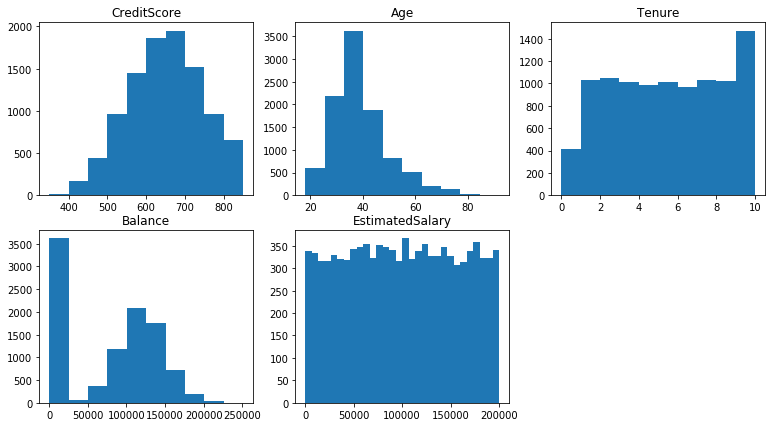

In [10]:
fig = plt.figure(figsize=(13,7))

ax1 = fig.add_subplot(2,3,1)
ax1.hist(data['CreditScore'])
ax1.set_title('CreditScore')

ax2 = fig.add_subplot(2,3,2)
ax2.hist(data['Age'], bins = 10)
ax2.set_title('Age')

ax3 = fig.add_subplot(2,3,3)
ax3.hist(data['Tenure'])
ax3.set_title('Tenure')

ax4 = fig.add_subplot(2,3,4)
ax4.hist(data['Balance'])
ax4.set_title('Balance')

ax4 = fig.add_subplot(2,3,5)
ax4.hist(data['EstimatedSalary'], bins=30)
ax4.set_title('EstimatedSalary')

- Ocena kredytowa rozkłada sie w miare normalnie
- Najczęstszy wiek klienta to 30 do 40 lat
- Większość klientów ma między 1 a 9 lat stażu zawodowego
- Stan konta (Balance) klientów którzy trzymają jakiekolwiek pieniądze w tym banku rozkłada sie normalnie, co w pewnym stopiu potwierdza wykres oceny kredytowej
- Ponad 3500 klientów, czyli ponad 35% nie trzyma żadnych pieniędzy na tym koncie. Możliwe powody:
 - Część osób mogła założć konto dla jednorazowej nagrody (akcje marketingowe banków)
 - ludzie nie mają pieniędzy. Z drugiej strony, na wykresie Tenure (staż pracy) widzimy że tylko ok 400 klientów ma mniej niż 1 rok stażu a ludzi bez pieniędzy jest ponad 3500
 - Pamiętamy, że prawie 80% zbioru to klienci którzy zrezygnowali z konta więc uzasadnione jest wyciągnięcie swoich pieniędzy przed likwidacją rachunku. Z drugiej strony można zadać pytanie "Dlaczego tylko 35% ludzi wybrało te pieniędze skoro wiemy, że 80% tego zbioru to klienci którzy zrezygnowali z konta?"
 - Ludzie są niezadowoleni z konta więc przenieśli swoje środki do innego banku, ale jeszcze nie zlikwidowali konta w tym banku

### Macierz korelacji

In [11]:
rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(10, 10))
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CustomerId,1,0.0053,0.0095,-0.015,-0.012,0.017,-0.014,0.0017,0.015,-0.0062
CreditScore,0.0053,1,-0.004,0.00084,0.0063,0.012,-0.0055,0.026,-0.0014,-0.027
Age,0.0095,-0.004,1,-0.01,0.028,-0.031,-0.012,0.085,-0.0072,0.29
Tenure,-0.015,0.00084,-0.01,1,-0.012,0.013,0.023,-0.028,0.0078,-0.014
Balance,-0.012,0.0063,0.028,-0.012,1,-0.3,-0.015,-0.01,0.013,0.12
NumOfProducts,0.017,0.012,-0.031,0.013,-0.3,1,0.0032,0.0096,0.014,-0.048
HasCrCard,-0.014,-0.0055,-0.012,0.023,-0.015,0.0032,1,-0.012,-0.0099,-0.0071
IsActiveMember,0.0017,0.026,0.085,-0.028,-0.01,0.0096,-0.012,1,-0.011,-0.16
EstimatedSalary,0.015,-0.0014,-0.0072,0.0078,0.013,0.014,-0.0099,-0.011,1,0.012
Exited,-0.0062,-0.027,0.29,-0.014,0.12,-0.048,-0.0071,-0.16,0.012,1



- Informacją o likwidacji konta (kolumna Exited) koreluje lekko dodatnio (0.12) ze stanem konta (potwierdziły to histogramy) oraz bardziej (0.29) z wiekiem - być może młodzi ludzie są bardziej bezkompromisowi i są bardziej skłonni odejść od firmy która nie spełnia ich warunków. To również może potwierdzać tezę o młodych ludziach zakładajacych konta w banku dla jednorazowej nagrody.

- Zauważalna ujemna korelacja między ilością produktów bankowych dołączonych do konta a stanem konta (Balance): -0.3

### Macierz korelacji dla zbioru bez klientow z zerowym saldem

In [12]:
data_without_cash = data[data['Balance'] > 0]

rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(10, 10))
corr = data_without_cash.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CustomerId,1,0.013,-0.0064,-0.029,-0.0087,0.018,-0.021,0.0023,0.016,-0.0074
CreditScore,0.013,1,-0.0095,0.0029,-0.0047,0.0089,-0.015,0.031,0.00057,-0.031
Age,-0.0064,-0.0095,1,0.0092,-0.013,0.0076,-0.02,0.063,-0.0086,0.3
Tenure,-0.029,0.0029,0.0092,1,0.0058,0.0065,0.026,-0.042,0.013,-0.0012
Balance,-0.0087,-0.0047,-0.013,0.0058,1,-0.001,0.0067,-0.02,-0.0019,0.017
NumOfProducts,0.018,0.0089,0.0076,0.0065,-0.001,1,0.0031,-0.0062,0.026,0.078
HasCrCard,-0.021,-0.015,-0.02,0.026,0.0067,0.0031,1,-0.018,-0.0044,-0.0021
IsActiveMember,0.0023,0.031,0.063,-0.042,-0.02,-0.0062,-0.018,1,-0.014,-0.17
EstimatedSalary,0.016,0.00057,-0.0086,0.013,-0.0019,0.026,-0.0044,-0.014,1,0.0063
Exited,-0.0074,-0.031,0.3,-0.0012,0.017,0.078,-0.0021,-0.17,0.0063,1


Obserwujemy wzrost zależności miedzy wiekiem a odejsciem oraz zanik wczesniejszej zaleznosci miedzy stanem konta a odejsciem gdyż wykluczlismy konta bez srodkow.

### Tworzenie koszykow dla kolumn Age i Exited

In [13]:
posortowane = sorted(data['Age'].unique())
_, bins = pd.qcut(posortowane, q=12, retbins=True) 
bins = np.around(bins).astype('int')
bins

array([18, 24, 30, 35, 41, 47, 52, 58, 64, 70, 76, 81, 92])

In [14]:
data['Age_bucket'] = pd.cut(data['Age'],bins=bins)

In [15]:
data['Age_bucket'] = pd.cut(data['Age'],bins=bins)

records_in_bucket = data[['Age_bucket', 'Exited']].groupby('Age_bucket').count()
records_in_bucket = records_in_bucket.reset_index()

exited_per_bucket = data[['Age_bucket', 'Exited']].groupby('Age_bucket').sum().reset_index()

result = pd.concat([exited_per_bucket, records_in_bucket['Exited']], axis=1, join='inner')
result.columns = ['Balance_bucket','exited_per_bucket','records_in_bucket']
result['exited_percent'] = round(result['exited_per_bucket'] / result['records_in_bucket'] * 100, 1)
result

,Balance_bucket,exited_per_bucket,records_in_bucket,exited_percent
0,"(18, 24]",38,435,8.7
1,"(24, 30]",108,1511,7.1
2,"(30, 35]",199,2185,9.1
3,"(35, 41]",408,2632,15.5
4,"(41, 47]",493,1505,32.8
5,"(47, 52]",356,670,53.1
6,"(52, 58]",256,452,56.6
7,"(58, 64]",134,306,43.8
8,"(64, 70]",32,149,21.5
9,"(70, 76]",10,99,10.1


- Wsrod wieku, najwiekszy odsetek ludzi ktorzy odeszlo są z przedzialu wiekowego 47 - 64 lat.

### Tworzenie koszyka dla kolumn Balance

In [16]:
posortowane = sorted(data['Balance'].unique())
bins = [-1, 25000, 50000, 75000, 100000, 125000, 150000, 175000, 200000, 1000000]
data['Balance_bucket'] = pd.cut(data['Balance'],bins=bins)

records_in_bucket = data[['Balance_bucket', 'Exited']].groupby('Balance_bucket').count()
records_in_bucket = records_in_bucket.reset_index()

exited_per_bucket = data[['Balance_bucket', 'Exited']].groupby('Balance_bucket').sum().reset_index()

result = pd.concat([exited_per_bucket, records_in_bucket['Exited']], axis=1, join='inner')
result.columns = ['Balance_bucket','exited_per_bucket','records_in_bucket']
result['exited_percent'] = round(result['exited_per_bucket'] / result['records_in_bucket'] * 100, 1)
result

,Balance_bucket,exited_per_bucket,records_in_bucket,exited_percent
0,"(-1, 25000]",504,3623,13.9
1,"(25000, 50000]",22,69,31.9
2,"(50000, 75000]",75,349,21.5
3,"(75000, 100000]",225,1160,19.4
4,"(100000, 125000]",558,2068,27.0
5,"(125000, 150000]",429,1762,24.3
6,"(150000, 175000]",156,738,21.1
7,"(175000, 200000]",49,197,24.9
8,"(200000, 1000000]",19,34,55.9


Najwiekszy odsetek ludzi (prawie 56%) odchodzi ze srodkami z najwiekszego koszyka pow. 200 tys euro

In [17]:
data[['EstimatedSalary','Balance', 'Gender']].groupby('Gender').mean().round(0).astype('int').reset_index()

,Gender,EstimatedSalary,Balance
0,Female,100602,75659
1,Male,99665,77174


Mezczyzni i kobiety maja średnio podobne pensje i stan konta